# Yield Curve Modelling and Principal Component Analysis

In this Jupyter notebook, I would like to show you how to show how PCA can enhance yield curve data analysis.

The main concept behind the PCA is to consider the correlation among features. If the correlation is very high among a subset of the features, PCA will attempt to combine the highly correlated features and represent this data with a smaller number of linearly uncorrelated features. The algorithm keeps performing this correlation reduction, finding the directions of maximum variance in the original high dimensional data and projecting them onto a smaller dimensional space. These newly derived components are known as principal components.
- Level
- Slope
- Curvature

PCA formalizes this viewpoint and allows us to evaluate when a segment of the yield curve has cheapened or richened beyond that prescribed by recent yield movements. The essence of PCA in the context of rates market is that most yield curve movements can be represented as a set of two to three independent driving factors the principal components (PCs) – along with their relative weightings. And, with these components, it is possible to reconstruct the original features.

Let us start by importing the necessary packages!

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
# Cufflinks library allows direct plotting of Plotly interactive charts from Dataframes object
import cufflinks as cf
cf.set_config_file(offline=True)

# Heatmap of covariance matrix
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# scikit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

## PCA

One of the main difficulties in today’s environment is being able to visualize data easily. Dimensionality is the number of dimensions, features or input variables associated in a dataset and dimensionality reduction means reducing the number of features in a dataset. Principal component analysis (PCA) is a linear dimensionality reduction technique with applications in exploratory data analysis, visualization and data preprocessing.

The decomposition achieves three purposes:
- Decorrelation: factors are independent and their covariance is zero.
- Dimensionality reduction: a few factors explain the majority of the variance
- Data structure revealed: the analysis operates under the assumption of no hidden factors.

These advantages often come at the cost of loosing the information and difficulty to find the attribution. The Principal Component Analysis is not just a calibration exercise (i.e., factors and their loadings change and tell nothing), but the systematic application of the analysis allows to see its predictive powers. For example, rotation of factors reveals the change in behaviour of market participants or cyclicality.

##### Eigenvectors and Eigenvalues: their role in PCA

In linear algebra, an eigenvector or characteristic vector is a vector that has its direction unchanged (or reversed) by a given linear transformation. More precisely, an eigenvector, $\mathbf {v}$ of a linear tranformation $T$, is scaled by a constant factor, $\lambda$ (its corresponding eigenvalue) when the transformation is applied to it (i.e. ${\displaystyle T\mathbf {v} =\lambda \mathbf {v} }$).

Eigenvalues and eigenvectors can be utilised to decomposed a matrix. Indeed, by the Spectral Theorem, the Covariance Matrix can be decomposed in:

$\Sigma = V\Lambda V^T$

where

- $\Lambda$ is a diagonal matrix with eigenvalues $\lambda _1 > \lambda _2 > ....> \lambda _n > 0 $, that we can write as:

${\displaystyle \operatorname {\Lambda} ={\begin{bmatrix}\lambda _{1}&&&0\\&\lambda _{2}\\&&\ddots \\0&&&\lambda _{n}\end{bmatrix}}}$


- $\operatorname {V}$ is a vectorised matrix of eigenvectors as:

${\displaystyle \operatorname {V} ={\begin{bmatrix} e _{1}& e _{2}\dots \ &e _{n}\end{bmatrix}}}$

- The eigenvectors $e(i)$ are orthogonal projections of the changes in data in directions of minimum variance, defined to the nearest sign (see Inverted Signs section below).2 Being orthogonal means that their covariance is zero: $Cov[e^{(i)}, e^{(j)}] = 0$. This property is the strength as well as weakness of the analysis.

Several properties below:

- Multiplying $VV^T = I$ gives an identity matrix, this applies to normalised eigenvectors.
- Confirmation of zero covariance:

$Cov[e^{(i)^T} \operatorname {X}, e^{(j)^T}\operatorname {X}] = e^{(i)^T} V\Lambda V^T e^{(j)^T} = [\Lambda]_{ij} = 0$

The fact that covariance of eigenvectors is zero makes it difficult (if not impossible) to create
analysis (strategies) that are based on simultaneous changes in several eigenmodes. This is a
problem in the light of the empirical phenomena of eigenvector rotation, for example.

##### Variance Explanation

Eigenvalue $\lambda_i$ is variance of the movements of a curve in each eigendirection. For example, the first factor explains:

$\displaystyle{\frac{\lambda_1}{\Sigma ^n _{i=1} \lambda _i}}$ of the total variance.

We would like to identify a few factors k that drive the evolution of the whole curve. To do this, just take eigenvectors with the largest corresponding eigenvalues. 

The goodness of fit statistic for the k-factor model is:

$\displaystyle{R^2 = \frac{\Sigma ^k _{i=1} \lambda _i}{\Sigma ^n _{i=1} \lambda _i}}$

##### Issues with PCA and its Numerical Methods

The same orthogonal basis can be represented by several combinations of eigenvectors that are linearly dependent. Therefore, numerical methods of matrix decomposition can produce seemingly different results. A few checks must be made:

- All eigenvalues must be positive and ranked.
- Some decompositions (e.g. QR) do not standardise eigenvectors (i.e. we would like $\sqrt{\Sigma _{k=1} e^2_{k}} = 1$)


We would like to represent the change as a combination of the PCA factors (i.e. $ \forall i: PC_i  $)

$\Delta f_j = PC_1 + PC_2 + ... + PC_i$


# Yield Curve Data Analysis

We are retrieving the following interest rates (Monthly government liability curve (nominal)) data through the Bank of England website (link: https://www.bankofengland.co.uk/statistics/yield-curves#):

- UK instantaneous nominal forward curve, short end
- UK instantaneous nominal forward curve
- UK nominal spot curve, short end
- UK nominal spot curve

For the purpose, we only used short end data.

In [5]:
path = 'C:/Users/domen/Downloads'
short_end_spot_data = pd.read_excel(f'{path}/GLC Nominal month end data_1970 to 2015.xlsx',sheet_name='3. spot, short end', header=3)

short_end_spot_data.set_index(keys='years:', inplace=True)
short_end_spot_data.drop(index='NaT', inplace=True)
# Assuming 'deltas' is the DataFrame
short_end_spot_data.columns = [f"{float(col):.5f}" if isinstance(col, (float, int)) else col.strip() for col in short_end_spot_data.columns]
short_end_spot_data.head()


0.08333  0.16667  0.25000  0.33333  0.41667  0.50000  0.58333   0.66667   0.75000   0.83333   0.91667   1.00000   1.08333   1.16667   1.25000   1.33333   1.41667   1.50000   1.58333   1.66667   1.75000   1.83333   1.91667   2.00000   2.08333   2.16667   2.25000   2.33333   2.41667   2.50000   2.58333   2.66667   2.75000   2.83333   2.91667   3.00000   3.08333   3.16667   3.25000   3.33333   3.41667   3.50000   3.58333   3.66667   3.75000   3.83333   3.91667   4.00000   4.08333   4.16667   4.25000   4.33333   4.41667   4.50000   4.58333   4.66667   4.75000   4.83333   4.91667   5.00000
years:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
1970-01-31      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN  8.635354  8.655828  8.672429  8.685536  8.695509  8.702695  8.707430  8.710039  8.710826  8.710067  8.707999  8.704827  8.700727  8.695855  8.690350  8.684328  8.677885  8.671102  8.664049  8.656782  8.649350  8.641795  8.634149  8.626444  8.618702  8.610945  8.603190  8.595453  8.587748  8.580085  8.572477  8.564931  8.557455  8.550055  8.542739  8.535509  8.528372  8.521329  8.514384  8.507538  8.500795  8.494154  8.487617  8.481185  8.474858  8.468637  8.462522  8.456513  8.450611
1970-02-28      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN       NaN       NaN  8.414515  8.413131  8.411356  8.409214  8.406724  8.403897  8.400743  8.397269  8.393491  8.389428  8.385102  8.380533  8.375741  8.370748  8.365574  8.360239  8.354761  8.349156  8.343442  8.337633  8.331744  8.325789  8.319784  8.313740  8.307671  8.301590  8.295508  8.289435  8.283380  8.277352  8.271357  8.265403  8.259494  8.253636  8.247834  8.242093  8.236415  8.230804  8.225265  8.219798  8.214407  8.209095  8.203863  8.198713  8.193647  8.188666  8.183771  8.178965  8.174246  8.169617
1970-03-31      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN       NaN  7.722785  7.734120  7.744187  7.753081  7.760888  7.767685  7.773548  7.778550  7.782761  7.786251  7.789084  7.791320  7.793018  7.794233  7.795017  7.795419  7.795482  7.795246  7.794748  7.794024  7.793104  7.792019  7.790794  7.789455  7.788023  7.786520  7.784963  7.783370  7.781753  7.780127  7.778501  7.776885  7.775288  7.773717  7.772179  7.770679  7.769223  7.767815  7.766459  7.765158  7.763914  7.762731  7.761611  7.760555  7.759564  7.758641  7.757786  7.757000  7.756285  7.755641  7.755068
1970-04-30      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN  7.393531  7.472025  7.542849  7.606512  7.663500  7.714283  7.759321  7.799062  7.833935  7.864352  7.890696  7.913332  7.932606  7.948855  7.962397  7.973522  7.982488  7.989529  7.994856  7.998668  8.001142  8.002442  8.002712  8.002083  8.000675  7.998598  7.995949  7.992814  7.989268  7.985380  7.981210  7.976813  7.972236  7.967524  7.962714  7.957844  7.952943  7.948042  7.943165  7.938335  7.933576  7.928904  7.924339  7.919894  7.915585  7.911422  7.907418  7.903580  7.899919  7.896440  7.893150  7.890054
1970-05-31      NaN      NaN      NaN      NaN      NaN      NaN      NaN  6.962894  7.088406  7.201104  7.301742  7.391107  7.470008  7.539268  7.599710  7.652127  7.697273  7.735838  7.768461  7.795740  7.818246  7.836513  7.851019  7.862182  7.870377  7.875937  7.879169  7.880349  7.879723  7.877510  7.873908  7.869093  7.863227  7.856453  7.848897  7.840673  7.831881  7.822611  7.8

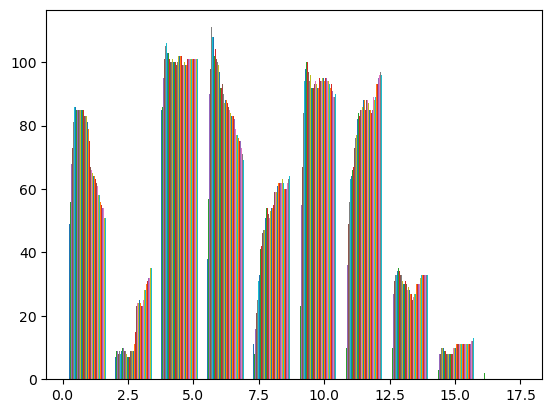

In [6]:
plt.hist(short_end_spot_data);

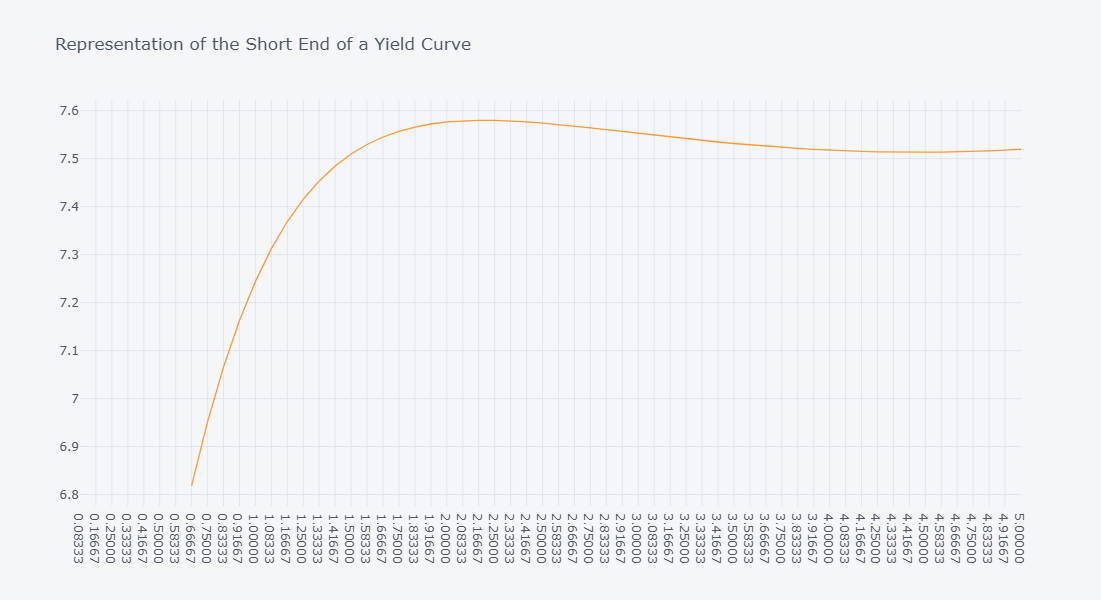

In [7]:
# Plot curve
short_end_spot_data.iloc[10].iplot(title = 'Representation of the Short End of a Yield Curve')

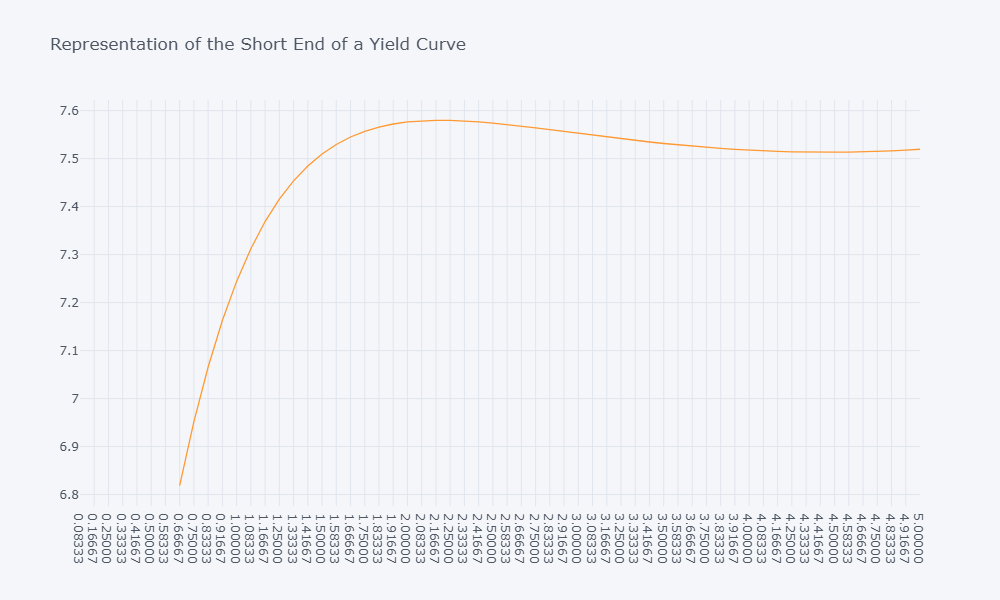

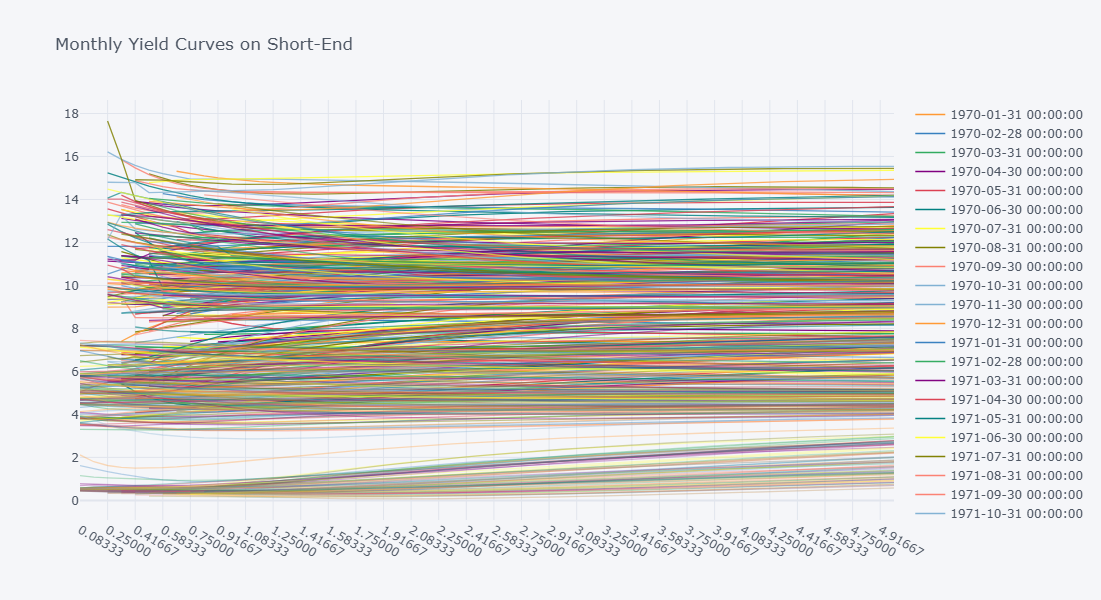

In [8]:
# Plot all curves
short_end_spot_data.T.iplot(title='Monthly Yield Curves on Short-End')

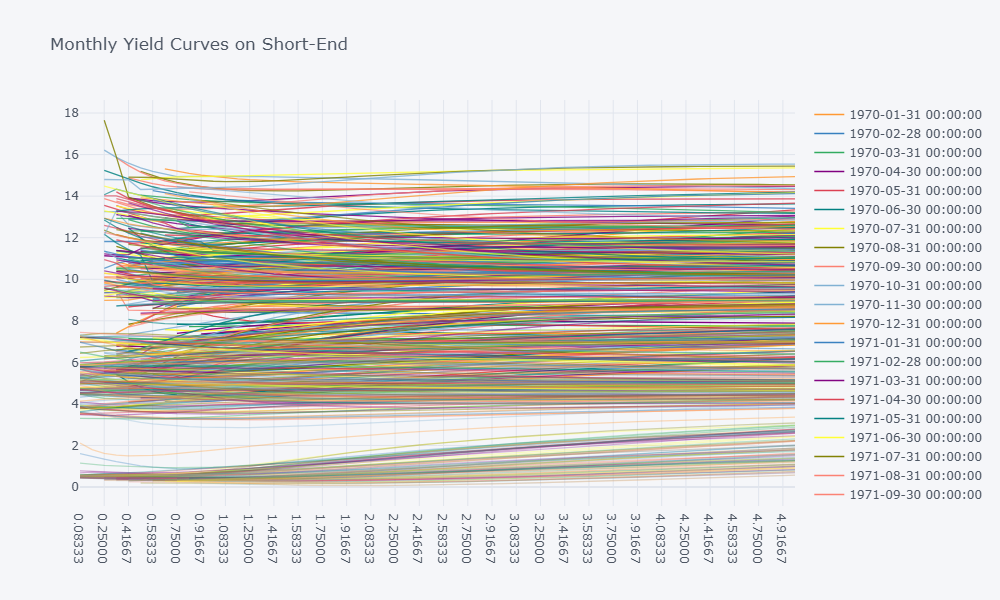

In [9]:
deltas = short_end_spot_data.diff(-1)
deltas.dropna(inplace=True)
deltas.head()

0.08333   0.16667   0.25000   0.33333   0.41667   0.50000   0.58333   0.66667   0.75000   0.83333   0.91667   1.00000   1.08333   1.16667   1.25000   1.33333   1.41667   1.50000   1.58333   1.66667   1.75000   1.83333   1.91667   2.00000   2.08333   2.16667   2.25000   2.33333   2.41667   2.50000   2.58333   2.66667   2.75000   2.83333   2.91667   3.00000   3.08333   3.16667   3.25000   3.33333   3.41667   3.50000   3.58333   3.66667   3.75000   3.83333   3.91667   4.00000   4.08333   4.16667   4.25000   4.33333   4.41667   4.50000   4.58333   4.66667   4.75000   4.83333   4.91667   5.00000
years:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1997-03-31 -0.089715 -0.150176 -0.159137 -0.143517 -0.118542 -0.090407 -0.062094 -0.035642 -0.012028  0.008671  0.026686  0.042376  0.056162  0.068412  0.079398  0.089322  0.098334  0.106550  0.114070  0.120983  0.127355  0.133238  0.138680  0.143721  0.148397  0.152739  0.156777  0.160536  0.164040  0.167311  0.170365  0.173220  0.175891  0.178389  0.180728  0.182917  0.184966  0.186884  0.188677  0.190354  0.191920  0.193382  0.194746  0.196017  0.197199  0.198297  0.199316  0.200258  0.201128  0.201929  0.202664  0.203336  0.203949  0.204504  0.205005  0.205453  0.205850  0.206200  0.206503  0.206762
1997-04-30 -0.167570 -0.111745 -0.084461 -0.075804 -0.076905 -0.082669 -0.089825 -0.096021 -0.100092 -0.101905 -0.101798 -0.100174 -0.097369 -0.093652 -0.089246 -0.084346 -0.079119 -0.073684 -0.068118 -0.062479 -0.056812 -0.051153 -0.045524 -0.039945 -0.034428 -0.028982 -0.023613 -0.018325 -0.013119 -0.007996 -0.002956  0.002002  0.006879  0.011676  0.016397  0.021043  0.025616  0.030120  0.034556  0.038928  0.043237  0.047487  0.051679  0.055816  0.059900  0.063933  0.067917  0.071854  0.075746  0.079595  0.083402  0.087169  0.090898  0.094589  0.098243  0.101863  0.105448  0.109001  0.112522  0.116011
1997-05-31 -0.201215 -0.266288 -0.306912 -0.326063 -0.330317 -0.325211 -0.314723 -0.301406 -0.286928 -0.272283 -0.257913 -0.244002 -0.230656 -0.217935 -0.205873 -0.194479 -0.183726 -0.173568 -0.163971 -0.154905 -0.146337 -0.138234 -0.130562 -0.123291 -0.116389 -0.109826 -0.103576 -0.097612 -0.091912 -0.086454 -0.081220 -0.076192 -0.071355 -0.066694 -0.062197 -0.057851 -0.053646 -0.049572 -0.045619 -0.041779 -0.038045 -0.034409 -0.030865 -0.027407 -0.024030 -0.020727 -0.017495 -0.014330 -0.011227 -0.008183 -0.005195 -0.002260  0.000626  0.003464  0.006256  0.009006  0.011714  0.014384  0.017015  0.019610
1997-06-30 -0.304178 -0.256277 -0.222969 -0.202719 -0.189102 -0.178300 -0.168140 -0.157897 -0.147636 -0.137472 -0.127453 -0.117637 -0.108087 -0.098872 -0.090063 -0.081687 -0.073733 -0.066194 -0.059062 -0.052323 -0.045959 -0.039951 -0.034280 -0.028924 -0.023863 -0.019078 -0.014551 -0.010264 -0.006202 -0.002349  0.001308  0.004783  0.008087  0.011232  0.014229  0.017086  0.019813  0.022419  0.024911  0.027298  0.029585  0.031780  0.033889  0.035918  0.037873  0.039758  0.041579  0.043340  0.045047  0.046702  0.048311  0.049877  0.051404  0.052895  0.054353  0.055782  0.057184  0.058563  0.059921  0.061261
1997-07-31 -0.237875 -0.204807 -0.178857 -0.155383 -0.136344 -0.121451 -0.110122 -0.101623 -0.095108 -0.089902 -0.085578 -0.081867 -0.078592 -0.075638 -0.072902 -0.070308 -0.067826 -0.065449 -0.063168 -0.060985 -0.058899 -0.056914 -0.055029 -0.053246 -0.051563 -0.049982 -0.048502 -0.047122 -0.045844 -0.044666 -0.043589 -0.042611 -0.041732 -0.040

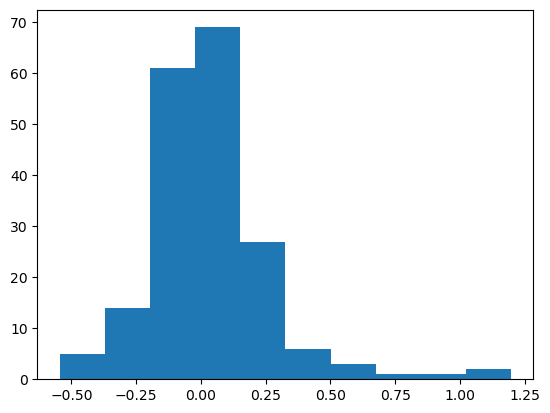

In [10]:
plt.hist(deltas['1.00000']);

In [11]:
vol = np.std(deltas, axis=0) * 10000

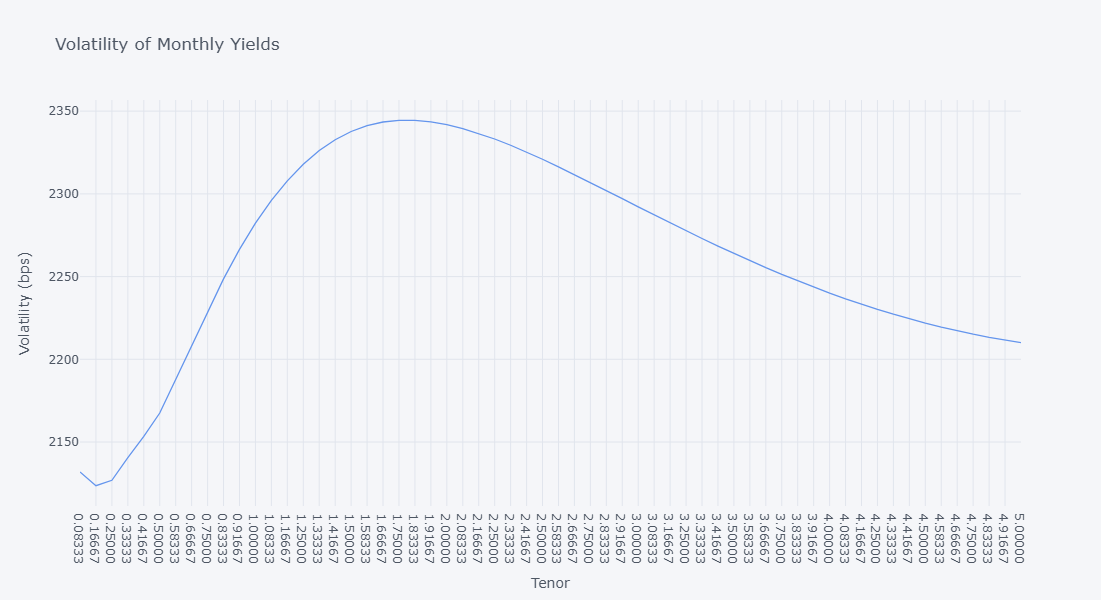

In [12]:
vol.iplot(title='Volatility of Monthly Yields', xTitle='Tenor', yTitle='Volatility (bps)', 
               color='cornflowerblue')

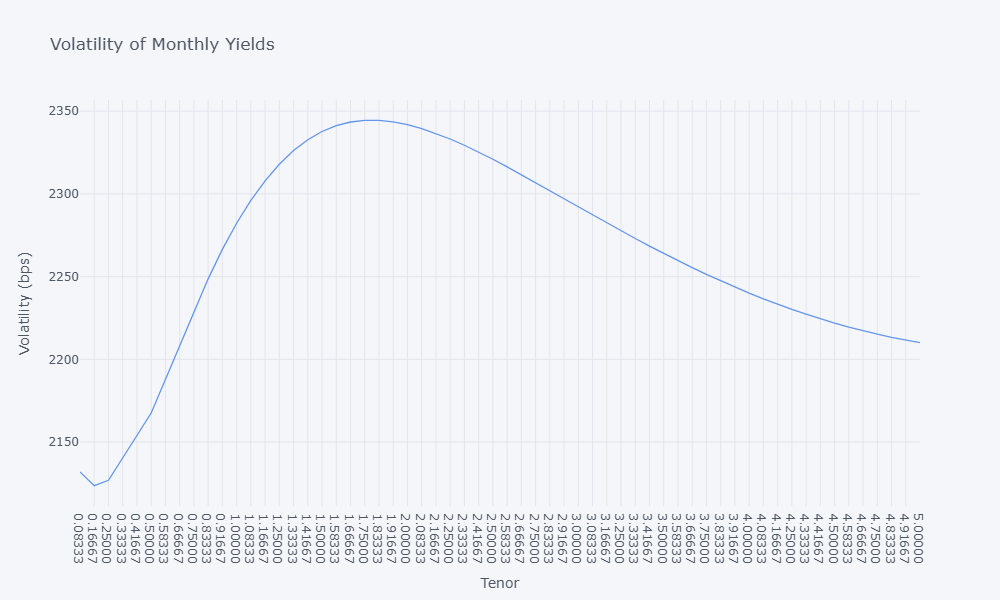

## Covariance Matrix of Deltas

In [13]:
cov_matrix= pd.DataFrame(np.cov(deltas, rowvar=False)*252/10000, 
                   columns=deltas.columns, index=deltas.columns)

cov_matrix.style.format("{:.4%}")

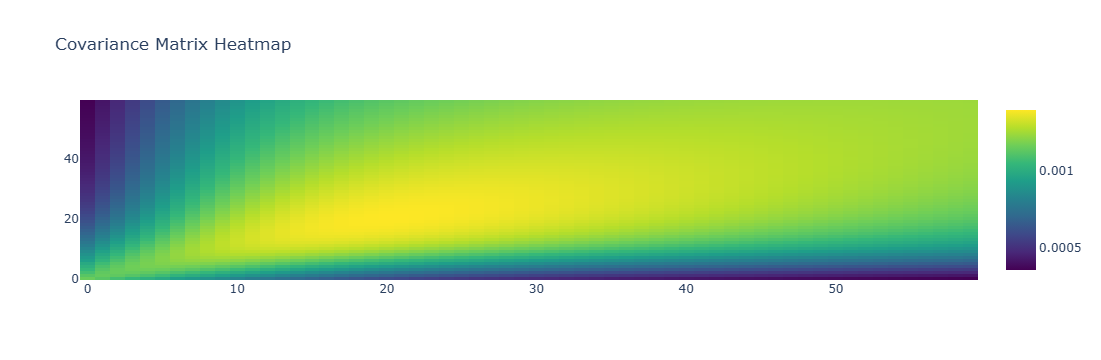

In [14]:
# Heatmap appropirate for Covariance Matrix
fig_matrix = go.Figure(data=go.Heatmap(z=cov_matrix, colorscale='Viridis'))
fig_matrix.update_layout(title='Covariance Matrix Heatmap')
fig_matrix.show()

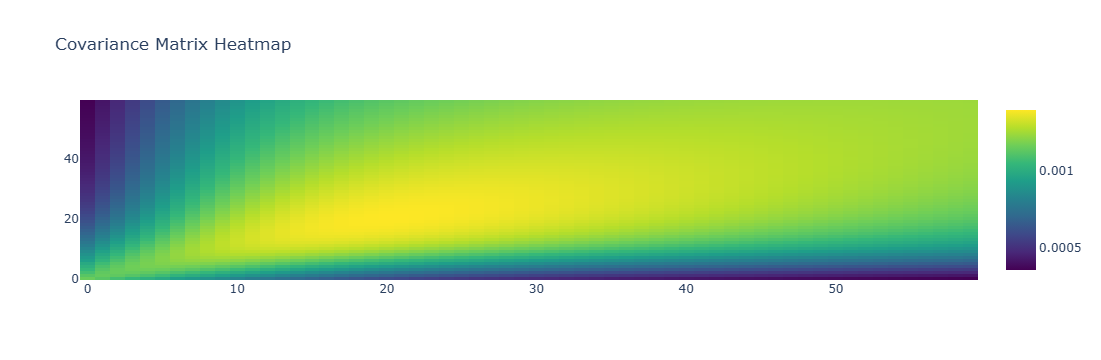

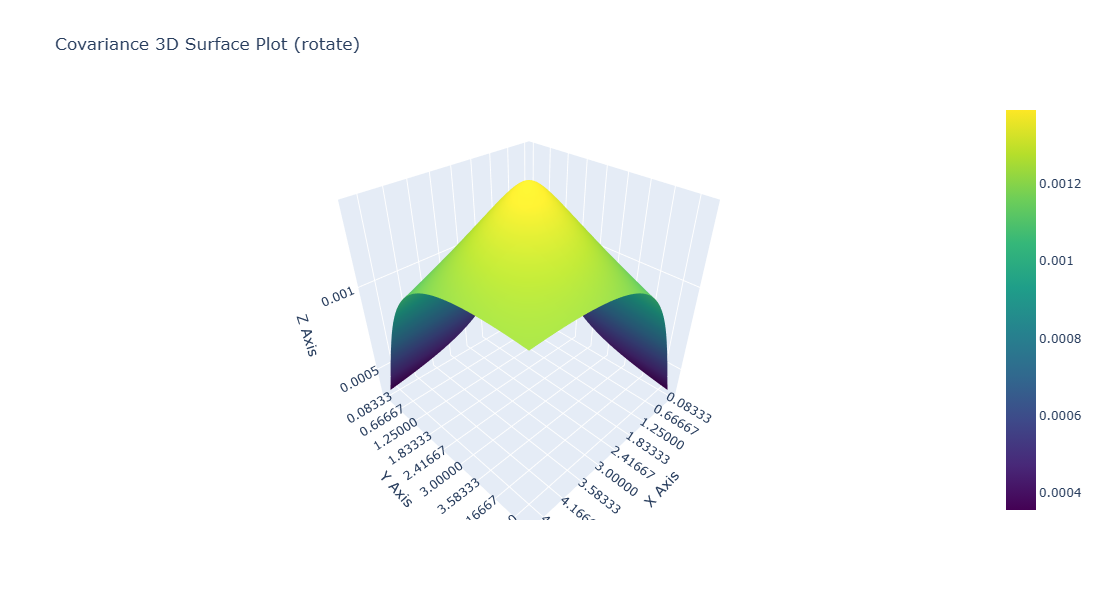

In [15]:
# 3D Surface Plot with larger dimensions
x, y = np.meshgrid(cov_matrix.columns, cov_matrix.index)
fig_surface = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])
fig_surface.add_trace(go.Surface(z=cov_matrix.values, x=x, y=y, colorscale='Viridis'))

# Update layout for larger dimensions
fig_surface.update_layout(title='Covariance 3D Surface Plot (rotate)',
                          scene=dict(
                              xaxis=dict(title='X Axis'),
                              yaxis=dict(title='Y Axis'),
                              zaxis=dict(title='Z Axis'),
                          ),
                          width=800,  # Adjust width as needed
                          height=600  # Adjust height as needed
                          )

# Show the plot
fig_surface.show()

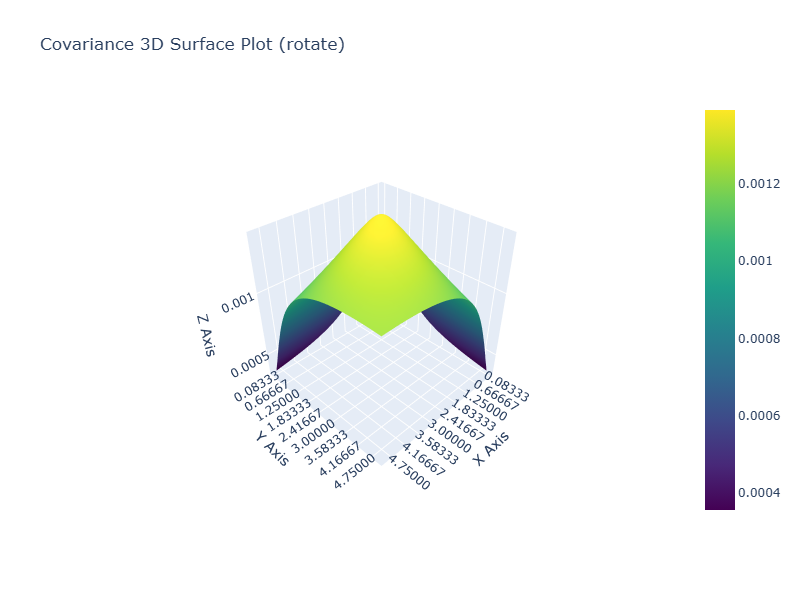

### Eigenvalue and Eigenvector calculation

In [16]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort values (good practice)
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Format into DataFrame 
df_eigval = pd.DataFrame({"Eigenvalues": eigenvalues})
df_eigval.head()

Eigenvalues
0     0.068370
1     0.007695
2     0.001563
3     0.000278
4     0.000074

In [17]:
# Work out explained proportion 
df_eigval["Variance Explained"] = df_eigval["Eigenvalues"] / np.sum(df_eigval["Eigenvalues"])
df_eigval = df_eigval[:8]

#Format as percentage
df_eigval.style.format({"Var Explained": "{:.2%}"})

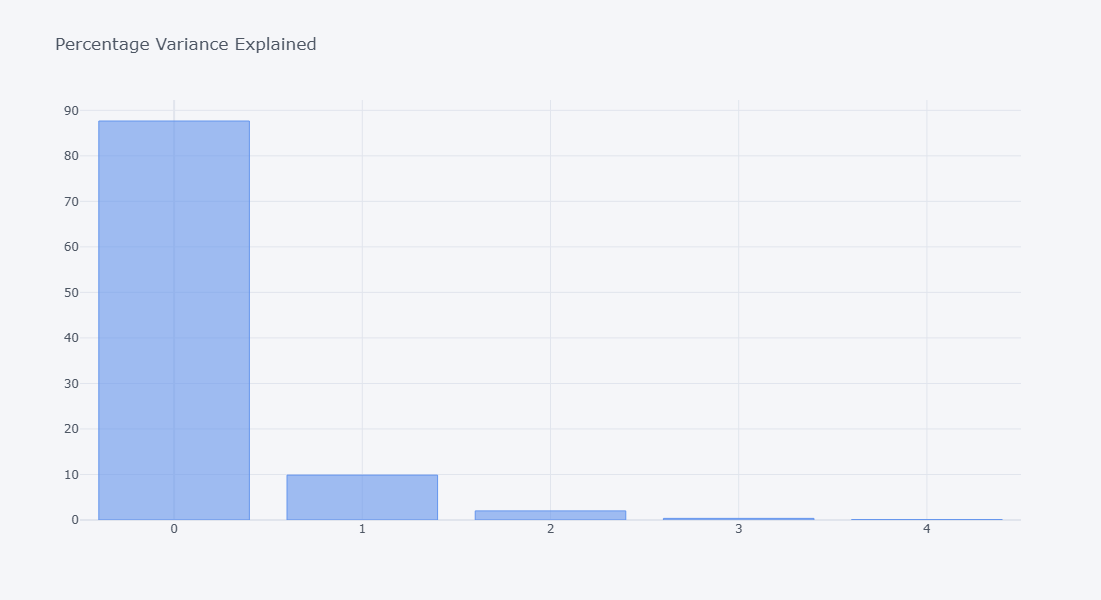

In [18]:
(df_eigval['Variance Explained'][:5]*100).iplot(kind='bar', title='Percentage Variance Explained', 
                                            color='cornflowerblue')

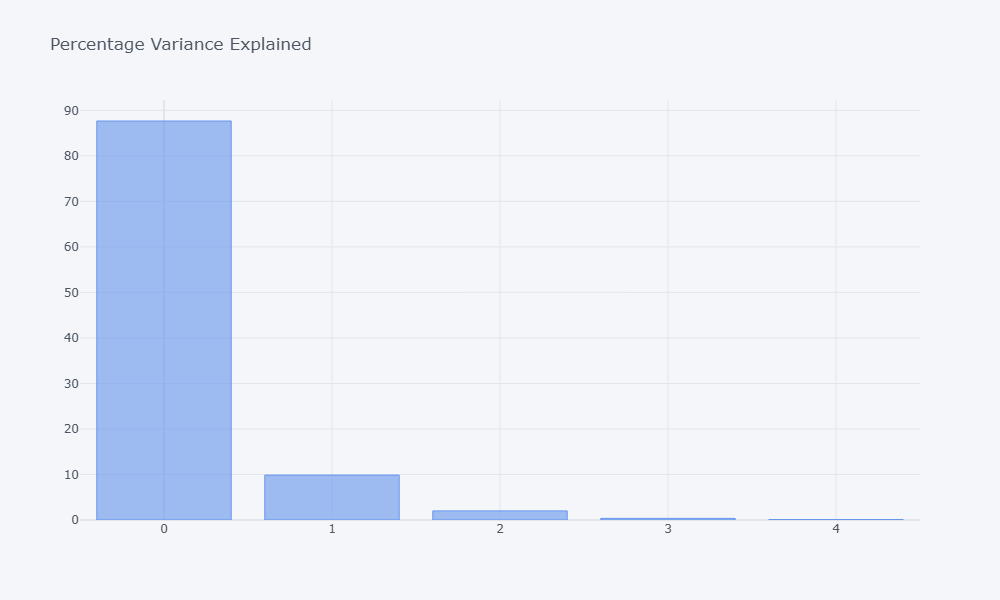

In [19]:
# Subsume first 3 components into a dataframe
pcadf = pd.DataFrame(eigenvectors[:,0:3], columns=['PC1','PC2','PC3'])
pcadf[:10]

PC1       PC2       PC3
0  0.062376 -0.279012 -0.337796
1  0.070832 -0.285868 -0.301675
2  0.078282 -0.283254 -0.252749
3  0.086140 -0.275407 -0.198205
4  0.093117 -0.263846 -0.150413
5  0.099893 -0.250114 -0.097953
6  0.106055 -0.234571 -0.039999
7  0.111759 -0.218149  0.000490
8  0.116796 -0.201080  0.035587
9  0.121168 -0.183770  0.065325

### Possible Interpretation: Factor Attribution

A likely interpretation of the Principal Components of the yield curve consists in identifying the below three factors, each of them driving:

- ##### Parallel shift in overall level of rates
This the largest principal component of forward curve movement, common to all tenors. ($PC_1$)

- ##### Steepening/flattening of the curve
This is the second component (i.e., change of skew across the term structure). It includes inverted curve (backwardation for commodities term structure) and it is $PC_2$.
- ##### Bending about specific maturity points
This is the third component to curve movement that mostly affects curvature (convexity).

### Conclusion

In the end, we were able to apply PCA to model the yield curve on the short end specifically and to understand the innermost principles of Principal Component Analysis both from a mathematical and coding perspective.